# Logo Recognition Algorithm with Flickr Logos Training Data

We chose to use data copied from: http://www.image.ntua.gr/iva/datasets/flickr_logos/

The Flickr Logos 27 dataset is an annotated logo dataset downloaded from Flickr and contains more than four thousand classes in total. It consists of **three image collections/sets**.

+ **The training set** contains **810 annotated images**, corresponding to **27 logo classes/brands (30 images for each class)**. All images are annotated with bounding boxes of the logo instances in the image. We allow multiple logo instances per class image. The training set is randomly split in six subsets, each one containing five images per class.

+ **The distractor set contains 4207 logo images/classes**, that depict, in most cases, clean logos. All images come from the Flickr group Identity + Logo Design. Each one of the distractor set images defines its own logo class and we regard the whole image as bounding box.

+ Finally, **the query set consists of 270 images**. There are five images for each of the 27 annotated classes, summing up to 135 images that contain logos. Furthermore, the query set contains 135 Flickr images that do not depict any logo class, giving 270 test images in total.

The brands included in the dataset are: Adidas, Apple, BMW, Citroen, Coca Cola, DHL, Fedex, Ferrari, Ford, Google, Heineken, HP, McDonalds, Mini, Nbc, Nike, Pepsi, Porsche, Puma, Red Bull, Sprite, Starbucks, Intel, Texaco, Unisef, Vodafone and Yahoo.

## Ideas for further developing project

+ Compare the impact of augmentation (and with that also the increase in data) on accuracy of model

+ Compare the improvement of accuracy when keeping color vs grey-scale and evaluate the tradeoff in terms of computing capacity


### Step 1: Accessing Raw Images Data and Labels

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tarfile
import os
from PIL import Image
import PIL.ImageEnhance as ImageEnhance
import requests
from concurrent.futures import ThreadPoolExecutor

In [5]:
"""Accessing Data (41.9s)"""

url = "http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz"
response = requests.get(url) # Send a get request to the URL
content = response.content #content in bytes

#saving the main file to specified directory with name "flickr27.tar"
filename = "flickr27.tar"
macbookuser = input("I am a macbook user (yes/no): ")
if macbookuser == "yes":
    specified_directory = input("Specify the path to the directory for which you want to store file (make sure to add / or \ at the end): ") #/Users/veronicalarsson/Downloads/
    image_path = "flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz"
    directory_separator = '/'
else:
    specified_direcotory = "r" + input("Specify the path to the directory for which you want to store file (make sure to add / or \ at the end): ")
    image_path = "flickr_logos_27_dataset\flickr_logos_27_dataset_images.tar.gz"
    directory_separator = '\\'

with open(specified_directory + filename, "wb") as file: #the file will be opened for writing in binary (b) mode, allowing you to write (w) binary data directly to the file
    file.write(content) #writing content to the specified filename with associated path

#to access the files, we need to open the main tar file, we then store the unzipped files in a new directory
tar_file_path = specified_directory + filename #path to tar.gz file
unzipped_path = specified_directory + "unzipped" #new path to unzipped content

with tarfile.open(tar_file_path, 'r:gz') as tar: #Open the tar.gz file and store all content in folder with specified path name
    tar.extractall(path= unzipped_path) 


#again we need to open a second tar file within the unzipped tar file for getting the raw images, we then store them in a new directory:
tar_file_path_2 = unzipped_path + directory_separator + image_path
unzipped_images_path= specified_directory + "unzipped_images"

with tarfile.open(tar_file_path_2, 'r:gz') as tar:
    tar.extractall(directory_separator + unzipped_images_path) #Extract all contents to a newly created directory

In [64]:
"""Getting dictionary with all filenames and images"""
# Path to directory containing image files
image_directory = unzipped_images_path+ directory_separator +'flickr_logos_27_dataset_images' #example: r'C:\Users\EmiliaGachowetz-Gepp\Documents\New ML\images\flickr_logos_27_dataset_images'

# List of all files (images) in the directory
image_filenames = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

# Opening and storing images in dictionary format (filename: , image: ) = images
def process_images(image_directory, image_filenames):
    image_dictionary = {}
    for filename in image_filenames:
        try:
            image_path = os.path.join(image_directory, filename) # Construct the full path to the image file
            img = Image.open(image_path) # Open the image using Pillow (PIL)
            img_resized = img.resize((227, 227), Image.LANCZOS) # Resize the image to 227x227 pixels using LANCZOS resampling filter (normalization)
            image_dictionary[filename] = img_resized

        except Exception as e:
            # Handle errors (e.g., if the image cannot be processed)
            print(f"Error processing image {filename}: {e}")

    return images

images_dictionary = process_images(image_directory, image_filenames)


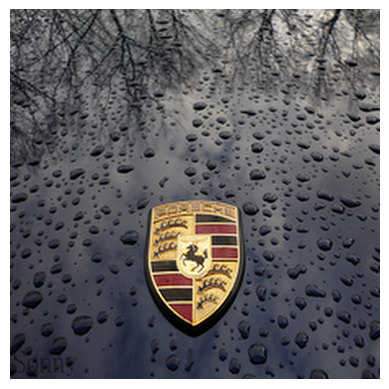

In [60]:
#viewing one picture from the data
some_pic = list(images.values())[0]

# Display the image using matplotlib
plt.imshow(some_pic, interpolation="lanczos")
plt.axis("off")
plt.show()

##### Saving data and associated labels in images_info:

The data frame is built like this:

+ Image filename (unique ID)

+ Class name (i.e. the label)

+ Training subset of class (1,...,6)

+ Coordinates of the top left and bottom right corners (x1 y1 x2 y2)

(x1 = top left horizontal, y1 = top left vertical, x2 = bottom right horizontal, y2 = bottom right vertical)

In [61]:
#2. read csv which contains information about images
images_info =pd.read_csv(unzipped_path + directory_separator + 'flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt', sep='\s+', header=None)

#renaming the columns in images_info:
new_column_names = ['Filename', 'Label', 'Subset', 'x1', 'y1','x2', 'y2']
images_info.columns=new_column_names
images_info.head()

# Save the dataset to computer using NumPy's .npz format
# np.savez(specified_directory + "my_dataset.npz", images=image_array)

,Filename,Label,Subset,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


### Step 2: Augmenting the image_array data

Data augmentation is a technique used in machine learning and deep learning to artificially increase the size of a training dataset by applying various transformations to the existing data. The goal is to enhance the model's generalization ability, robustness, and performance by exposing it to a more diverse set of examples during training. This technique is particularly useful when the available dataset is limited.

Common data augmentation techniques include:

1. **Rotation:** Rotating images by a certain degree.
2. **Flip:** Flipping images horizontally or vertically.
3. **Zoom:** Zooming in or out of images.
4. **Translation:** Shifting images horizontally or vertically.
5. **Shear:** Applying a shearing transformation to images.
6. **Brightness and Contrast Adjustment:** Changing the brightness and contrast of images.
7. **Noise Injection:** Adding random noise to images.
8. **Color Jittering:** Adjusting the color values of images.

For example, in image classification tasks, if you have a dataset of cat images, you can apply data augmentation to generate variations of the same images by rotating, flipping, zooming, or changing their colors. This way, the model sees different perspectives of the same data during training, which can help it become more robust to variations and improve its performance on new, unseen data.

In deep learning frameworks and libraries, there are often built-in tools or functions for applying data augmentation during the training process. This allows practitioners to easily incorporate these transformations into their pipelines without manually creating augmented datasets.

In [68]:
"""Augmenting all images (13.2s)"""

def augment_images(images_dictionary, augmented_df):
    '''This function crops, rotates, and scales images and saves them in the specified output folder'''
    dataframes = []  # List to store DataFrames

    for index, row in augmented_df.iterrows(): #loops through each image
        filename = row['Filename']
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']

        # Find the original image by finding matching filename in dictionary
        original_image = None
        for name, image in images_dictionary.items():
            if name == filename:
                original_image = image
                break

        # Rotate, scale, and crop the image
        operations = ['original','rotated', 'scaled', 'cropped', 'top-bottom flipped']
        images = [original_image, 
                  original_image.rotate(45), 
                  original_image.resize((int(original_image.width * 1.5), int(original_image.height * 1.5))), 
                  original_image.crop((x1, y1, x2, y2)), 
                  original_image.transpose(Image.FLIP_TOP_BOTTOM)]

        for i in range(len(operations)):
            op = operations[i]
            img = images[i]
            data = {'Filename': [filename], 'Operation': [op], 'Image': [img]}
            df = pd.DataFrame(data)
            dataframes.append(df)

        # Concatenate all DataFrames in the list
        modified_df = pd.concat(dataframes, ignore_index=True)

        return modified_df

# Storing the augmented df which also contains the original data
augmented_df = augment_images(images_dictionary, images_info)

# Merging with images_info to give the augmented images their labels
labelled_augmented_df = pd.merge(augmented_df, images_info, on='Filename', how='inner') #if we have inner join we will only keep images that are augmented
labelled_augmented_df = labelled_augmented_df.drop(['Filename'], axis=1) #dropping unnecessary column
labelled_augmented_df.head()

,Operation,Image,Label,Subset,x1,y1,x2,y2
0,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,1,38,12,234,142
1,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,2,38,12,234,142
2,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,3,38,12,234,142
3,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,4,38,12,234,142
4,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,5,38,12,234,142


### Step 3: Grey-scaling data to reduce pixels and computation capacity (consider if we should compare learning for the two different versions?)

In [41]:
#storing data as grey-scale
labelled_augmented_df['Grey-Scale Image'] = labelled_augmented_df['Image'].apply(lambda img: ImageEnhance.Color(img).enhance(0))
labelled_augmented_df.head()

,Operation,Image,Label,Subset,x1,y1,x2,y2,Grey-Scale Image
0,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,1,38,12,234,142,<PIL.Image.Image image mode=RGB size=227x227 a...
1,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,2,38,12,234,142,<PIL.Image.Image image mode=RGB size=227x227 a...
2,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,3,38,12,234,142,<PIL.Image.Image image mode=RGB size=227x227 a...
3,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,4,38,12,234,142,<PIL.Image.Image image mode=RGB size=227x227 a...
4,original,<PIL.Image.Image image mode=RGB size=227x227 a...,Adidas,5,38,12,234,142,<PIL.Image.Image image mode=RGB size=227x227 a...
